### MÁSTER UNIVERSITARIO EN CIENCIA DE DATOS E INGENIERÍA DE COMPUTADORES
### Trabajo Fin de Máster 2024
##### Detección temprana del trastorno del espectro autista mediante inteligencia artificial confiable
##### Alumno: *Carlos Santiago Sánchez Muñoz*, Tutor: *Alberto Fernández Hilario*

En este cuaderno se va a realizar el aprendizaje del dataset utilizando extracción de características en imágenes mediante el descriptor HOG y SVM.

In [ ]:
#!pip install imgaug

In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import imgaug.augmenters as iaa

In [2]:
PATH_TRAIN_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Train/TSImages/"
PATH_TRAIN_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Train/TCImages/"
PATH_TEST_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Test/TSImages/"
PATH_TEST_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Test/TCImages/"

PATH_RESULT_POSITIVE = "C:/Users/Carlos/Downloads/TFM_data/Result/TSImages/"
PATH_RESULT_NEGATIVE = "C:/Users/Carlos/Downloads/TFM_data/Result/TCImages/"
EXAMPLES_POSITIVE = ["TS032_11.png", "TS046_15.png"]
EXAMPLES_NEGATIVE = ["TC028_30.png", "TC046_37.png", "TC055_30.png"]

IMAGE_EXTENSION = ".png"
NROW = 128  # Alto al que redimensionar
NCOL = 128  # Ancho al que redimensionar
NDEC = 3 # Redondeo de decimales en resultados
RADIUS = 3 # Radio de LBP
N_POINTS = 8 * RADIUS # Número de puntos LBP

MODEL = "SVM"   # "KNN", "SVM"
THRESHOLD = 0.6
CLASSES_MP = ["Non ASD", "Low", "Mild", "Severe"]
NUM_AUGMENTATIONS = 2

In [3]:
path = 'C:/Users/Carlos/Downloads/TFM_data/'

# Lee el archivo CSV con los metadatos y lo guarda en un DataFrame
metadata = pd.read_csv(path + 'Metadata/Metadata_Participants.csv')

# Muestra las primeras filas del DataFrame
print(metadata.head())

   ParticipantID Gender Date of Presentation  Age Class  CARS Score
0              1      M           27/04/2015  7.0    TS        32.5
1              2      F           28/04/2015  8.9    TS        36.5
2              3      M           28/04/2015  4.4    TS        27.0
3              4      M           29/04/2015  6.9    TS        35.0
4              5      M           06/05/2015  8.9    TS        31.0


In [4]:
def preprocess_image(image: np.array) -> np.array:
    """
        Preprocesa las imágenes: convierte a gris y cambia el tamaño.

        Parameters:
            image (np.array): imagen a preprocesar

        Returns:
            np.array: image preprocesada
    """
    #print("Tamaño de image: " + str(image.shape))
    # Obtenemos una versión en nivel de gris
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print("Tamaño de image en gris: " + str(gris.shape))
    # Redimensionar la image al nuevo tamaño
    return cv2.resize(gris, (NCOL, NROW))

def HLBP(image: np.array, method: str, eps: float=1e-7) -> np.array:
    """
    Lee las imágenes (positivas y negativas) y calcula sus descriptores.

    Parameters:
        image (np.array): image a preprocesar.
        method (string): LBP method to use.
        eps (float): a small value to avoid dividing by zero.

    Returns:
        np.array: descriptor
    """ 
    if image is None or image.size == 0:
        raise ValueError("La imagen de entrada no debe estar vacía.")
    
    lbp = local_binary_pattern(image, N_POINTS, RADIUS, method)
    (descriptor, _) = np.histogram(lbp.ravel(), bins=np.arange(0, N_POINTS + 3), range=(0, N_POINTS + 2))
    # normalize the histogram
    descriptor = descriptor.astype("float")
    descriptor /= (descriptor.sum() + eps)

    return descriptor

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(
        rotate=(-20, 20),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        scale=(0.9, 1.1)
    ),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0, 0.5))
])

def augment_instance(instance: np.ndarray) -> np.ndarray:
    """
    Aplica augmentations a una instancia de datos.

    Parameters:
        instance (np.ndarray): La instancia de datos a ser aumentada.

    Returns:
        np.ndarray: La instancia de datos aumentada.
    """
    return augmentation(image=instance)

def load_data(desc: str, path_pos: str, path_neg: str,
              n_augmentations: int=0) -> tuple[np.array, np.array, np.array]:
    """
    Lee las imágenes (positivas y negativas) y calcula sus descriptores.

    Parameters:
        desc (string): descriptor a emplear ('HOG', 'LBP', 'LBPU').
        path_pos (string): path with the positive examples
        path_neg (string): path with the negative examples
        n_augmentations (int): number of augmentations. By default, 0.

    Returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    ids = []

    # Casos positivos
    counter_positive_samples = 0
    for filename in os.listdir(path_pos):
        if filename.endswith(IMAGE_EXTENSION):
            img_list = []
            img_list.append(cv2.imread(path_pos + filename))
            the_id = int(filename.split('_')[1].split('.')[0])

            # Augment image
            for _ in range(n_augmentations):
                img_list.append(augment_instance(img_list[0]))

            for img in img_list:
                img = preprocess_image(img)

                if desc=='HOG':
                    hog = cv2.HOGDescriptor()
                    #hog = cv2.HOGDescriptor(_winSize=(64,32),
                    #                        _blockSize=(32,16),
                    #                        _blockStride=(16,8),
                    #                        _cellSize=(16,8),
                    #                        _nbins=9)
                    descriptor = hog.compute(img)
                elif desc=='LBP':
                    descriptor = HLBP(img, "default")
                elif desc=='LBPU':
                    descriptor = HLBP(img, "uniform")
                else:
                    print("ERROR: descriptor inválido")
                    return None
                
                training_data.append(descriptor)
                classes.append(1)
                ids.append(the_id)
                counter_positive_samples += 1

    print("Leidas " + str(counter_positive_samples) + " imágenes -> positivas")

    # Casos negativos
    counter_negative_samples = 0
    for filename in os.listdir(path_neg):
        if filename.endswith(IMAGE_EXTENSION):
            img_list = []
            img_list.append(cv2.imread(path_neg + filename))
            the_id = int(filename.split('_')[1].split('.')[0])

            # Augment image
            for _ in range(n_augmentations):
                img_list.append(augment_instance(img_list[0]))

            for img in img_list:
                img = preprocess_image(cv2.imread(path_neg + filename))

                if desc=='HOG':
                    hog = cv2.HOGDescriptor()
                    #hog = cv2.HOGDescriptor(_winSize=(64,32),
                    #                        _blockSize=(32,16),
                    #                        _blockStride=(16,8),
                    #                        _cellSize=(16,8),
                    #                        _nbins=9)
                    descriptor = hog.compute(img)
                elif desc=='LBP':
                    descriptor = HLBP(img, "default")
                elif desc=='LBPU':
                    descriptor = HLBP(img, "uniform")
                else:
                    print("ERROR: descriptor inválido")
                    return None
                
                training_data.append(descriptor)
                classes.append(0)
                ids.append(the_id)
                counter_negative_samples += 1
    
    print("Leidas " + str(counter_negative_samples) + " imágenes -> negativas")

    return np.array(training_data), np.array(classes), np.array(ids)

def calculate_ratio(pred: list[int], ids: list[int]) -> dict:
    """
    Calcula el ratio (promedio) de predicciones postivas para cada id.
    
    Parameters:
        pred (list[int]): predicciones
        ids (list[int]): identificadores
    
    Returns:
        dict: ratios
    """
    if len(pred) != len(ids):
        raise ValueError("Las listas 'pred' e 'ids' deben tener la misma longitud.")
    
    count_dict = {}
    sum_dict = {}
    
    for p, i in zip(pred, ids):
        if i not in count_dict:
            count_dict[i] = 0
            sum_dict[i] = 0
        count_dict[i] += 1
        sum_dict[i] += p
    
    result = {}
    for i in count_dict:
        result[i] = sum_dict[i] / count_dict[i]
    
    return result

def calculate_max(pred: list[int], ids: list[int]) -> dict:
    """
    Calcula el valor máximo de predicciones para cada id.
    
    Parameters:
        pred (list[int]): predicciones
        ids (list[int]): identificadores
    
    Returns:
        dict: máximos valores para cada id
    """
    if len(pred) != len(ids):
        raise ValueError("Las listas 'pred' e 'ids' deben tener la misma longitud.")
    
    max_dict = {}
    
    for p, i in zip(pred, ids):
        if i not in max_dict:
            max_dict[i] = p
        else:
            if p > max_dict[i]:
                max_dict[i] = p
    
    return max_dict

def thresholding(dict: dict, threshold: float=0.2) -> dict:
    """
    Umbraliza a partir de un límite dado.
    
    Parameters:
        dict: diccionario de valores
        threshold: límite para la umbralización
    
    Returns:
        int dictonary: diccionario umbralizado
    """ 
    for clave, valor in dict.items():
        if valor > threshold:
            dict[clave] = 1
        else:
            dict[clave] = 0
    
    return dict

def thresholding_new(dict: dict, threshold: list[float]=[0.2], labels:list[int]=[0,1]) -> dict:
    """
    Umbraliza a partir de un límite dado.
    
    Parameters:
        dict: diccionario de valores
        threshold: límites para la umbralización
        labels: etiquetas
    
    Returns:
        int dictonary: diccionario umbralizado
    """ 
    for clave, valor in dict.items():
        for i in range(len(threshold)):
            if(valor<=threshold[i]):
                dict[clave] = labels[i]
                break
            elif(i==(len(threshold)-1)):
                dict[clave] = labels[i+1]
    
    return dict

def confusion_matrix_customized(y_train:list[int], y_pred: list[int],title: str='Confusion Matrix',
                                classes: list[str]=['TD', 'ASD']) -> np.ndarray:
    """
    Genera una imagen con la matriz de confusión.
    
    Parameters:
        y_train (list[int]): clases reales del conjunto de train.
        y_pred (list[str]): estimaciones del clasificador.
        title (str): title of the plot. By default, 'Confusion Matrix'.
        classes (list[str]): classes label. By default, ['TD', 'ASD'].
    
    Returns:
        np.ndarray: confusion matrix
    """
    conf_matrix = metrics.confusion_matrix(y_train, y_pred)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(6,5))
    # Scale up the size of all text
    sns.set(font_scale = 1.3)
    # Plot Confusion Matrix using Seaborn heatmap()
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d') # cmap="Blues"
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(classes)
    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(classes)
    # set plot title
    ax.set_title(title, fontsize=14, pad=20)

    plt.show()

    return conf_matrix

def results(y_test: list[int], y_pred: list[int], title:str = 'Confusion matrix',
            classes: list[str]=['TD', 'ASD']) -> tuple[float, float, float, float, float]:
    """
    Calculates some metrics for the preditions obtained.
    It plots a confusion  matix.
    
    Parameters:
        y_test: real classes.
        y_pred: predicions of the classifier..
        title (str): title of the plot. By default, 'Confusion Matrix'..
    
    Returns:
        float: accuracy
        float: precision
        float: sensitivity_recall
        float: specificity
        float: F1_score
    """
    accuracy = metrics.accuracy_score(y_test, y_pred).round(NDEC)
    precision = metrics.precision_score(y_test, y_pred).round(NDEC)
    sensitivity_recall = metrics.recall_score(y_test, y_pred).round(NDEC)
    specificity = metrics.recall_score(y_test, y_pred, pos_label=0).round(NDEC)
    F1_score = metrics.f1_score(y_test, y_pred).round(NDEC)

    print({"Accuracy":accuracy, "Precision":precision, "Sensitivity_recall":sensitivity_recall,
           "Specificity":specificity,"F1_score":F1_score})
    
    confusion_matrix_customized(y_test, y_pred, title, classes)
    
    return accuracy, precision, sensitivity_recall, specificity, F1_score

def change_MIL(y_test:list[int], y_pred:list[int], IDS:list[int], verbose:bool=False) -> tuple[list[int], list[int]]:
    """
    Calcula el ratio de predecciones postivas para cada id.
    
    Parameters:
        y_test (list[int]): real classes.
        y_pred (list[int]): predicions of the classifier.
        ids (list[int]): identificadores
    
    Returns:
        tuple[list[int], list[int]]: ratios
    """
    y_pred_ratio = calculate_ratio(y_pred, IDS)
    if(verbose):
        print(list(y_pred_ratio.values()))
    y_pred_ratio = thresholding(y_pred_ratio, THRESHOLD)
    y_pred_ratio = list(y_pred_ratio.values())
    y_test_ratio = calculate_ratio(y_test, IDS)
    y_test_ratio = [int(val) for val in y_test_ratio.values()]

    return y_test_ratio, y_pred_ratio

def change_MIL_multiclass(y_test:list[int], y_pred:list[int], IDS:list[int], verbose:bool=False) -> tuple[list[int], list[int]]:
    """
    Calcula el ratio de predecciones postivas para cada id.
    
    Parameters:
        y_test (list[int]): real classes.
        y_pred (list[int]): predicions of the classifier.
        ids (list[int]): identificadores
    
    Returns:
        tuple[list[int], list[int]]: ratios
    """
    #y_pred_ratio = calculate_max(y_pred, IDS)
    y_pred_ratio = calculate_ratio(y_pred, IDS)
    if(verbose):
        print(list(y_pred_ratio.values()))
    y_pred_ratio = thresholding_new(y_pred_ratio, [0.45, 1.0, 2.5], [0,1,2,3])
    y_pred_ratio = list(y_pred_ratio.values())
    y_test_ratio = calculate_max(y_test, IDS)
    y_test_ratio = [int(val) for val in y_test_ratio.values()]

    return y_test_ratio, y_pred_ratio

Lectura de datos vía el descriptor indicado.

In [5]:
# Obtenemos los datos para el entrenamiento del clasificador
X_train, y_train, IDs_train = load_data('HOG', PATH_TRAIN_POSITIVE, PATH_TRAIN_NEGATIVE,
                                        NUM_AUGMENTATIONS) # Choose 'HOG', 'LBP' o 'LBPU'
X_test, y_test, IDs_test = load_data('HOG', PATH_TEST_POSITIVE, PATH_TEST_NEGATIVE)   # Choose 'HOG', 'LBP' o 'LBPU'

print("Instancias para entrenamiento: " + str(X_train.shape))
print("Instancias para test: " + str(X_test.shape))

Leidas 549 imágenes -> positivas
Leidas 891 imágenes -> negativas
Leidas 36 imágenes -> positivas
Leidas 31 imágenes -> negativas
Instancias para entrenamiento: (1440, 34020)
Instancias para test: (67, 34020)


## Clasifiación binaria

Vamos a usar la validación cruzada que viene implícita en *GridSearch*, encontrando por tanto los mejores parámetros de ajuste de estas imágenes (entre los indicados en el grid).

In [6]:
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#print(clf.score(X_test, y_test))

#svm = svm.SVC(kernel='linear', C=10, random_state=42)
#scores = cross_val_score(svm, X, y, cv=5)

if(MODEL=="KNN"): # Define parameter grid and model for KNN
    #params = {
    #    'n_neighbors': [3, 5, 7],                           # Different values for the number of neighbors
    #    'weights': ['uniform', 'distance'],                 # Different weighting methods
    #    'metric': ['euclidean', 'manhattan', 'chebyshev']   # Different distance metrics
    #}
    params = { 'n_neighbors': [3], 'weights': ['uniform'], 'metric': ['euclidean'] }
    model = KNeighborsClassifier()
elif(MODEL=="SVM"): # Define parameter grid and model for SVC
    #params = [{'C':[1,10,100], 'kernel':['linear', 'poly']},
    #          {'C':[1,10,100], 'kernel':['rbf'], 'gamma':[5, 1, 0.2]}]
    params = [{'C':[1], 'kernel':['poly']}]
    model = svm.SVC()
else:
    print("Modelo inválido. Elija 'KNN' o 'SVM'.")

gs = GridSearchCV(estimator = model, param_grid=params, scoring='accuracy', cv=5)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7701388888888888
{'C': 1, 'kernel': 'poly'}


Evaluamos resultados. Se puede cambiar y volver a ejecutar con otro descriptor.

[0.8181818181818182, 0.9777777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9393939393939394, 0.9666666666666667, 0.2, 0.5555555555555556, 0.8444444444444444, 0.8571428571428571, 0.9696969696969697, 0.9487179487179487, 0.8571428571428571, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'Accuracy': 0.958, 'Precision': 1.0, 'Sensitivity_recall': 0.891, 'Specificity': 1.0, 'F1_score': 0.942}


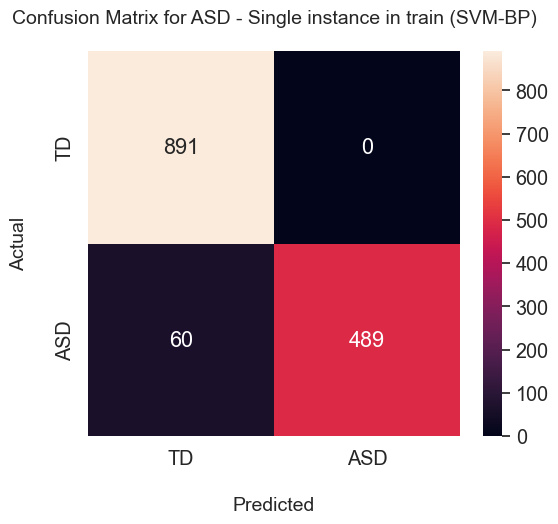

{'Accuracy': 0.976, 'Precision': 1.0, 'Sensitivity_recall': 0.95, 'Specificity': 1.0, 'F1_score': 0.974}


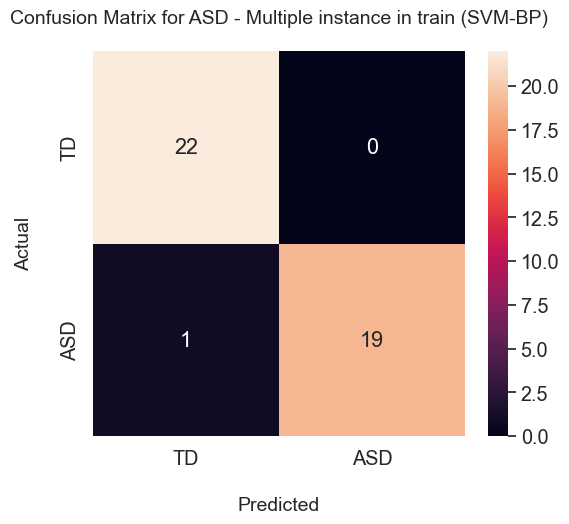

(0.976, 1.0, 0.95, 1.0, 0.974)

In [22]:
THRESHOLD=0.45
# Realizamos predicciones sobre el conjunto de train
y_pred = gs.predict(X_train)
y_train_ratio, y_pred_ratio = change_MIL(y_train, y_pred, IDs_train, True)

results(y_train, y_pred, "Confusion Matrix for ASD - Single instance in train (" + MODEL + "-BP)")
results(y_train_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in train (" + MODEL + "-BP)")

[1.0, 1.0, 0.6363636363636364, 1.0, 1.0, 0.8333333333333334, 0.0, 0.25, 0.0, 0.42857142857142855, 0.0, 0.42857142857142855]
{18: 1, 9: 1, 5: 1, 8: 1, 16: 1, 23: 1, 31: 0, 48: 0, 55: 0, 53: 0, 56: 0, 38: 0}
{'Accuracy': 0.806, 'Precision': 0.795, 'Sensitivity_recall': 0.861, 'Specificity': 0.742, 'F1_score': 0.827}


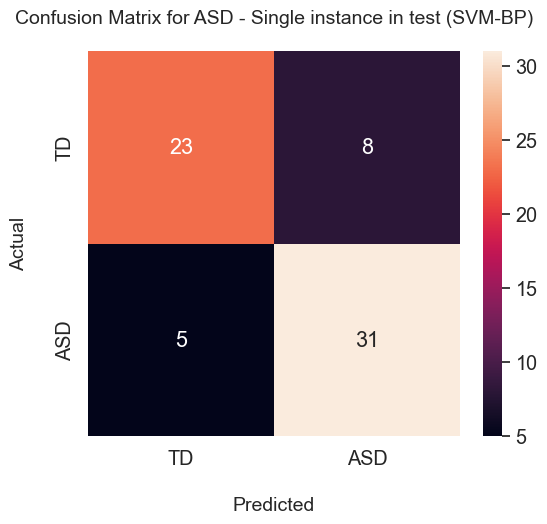

{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity_recall': 1.0, 'Specificity': 1.0, 'F1_score': 1.0}


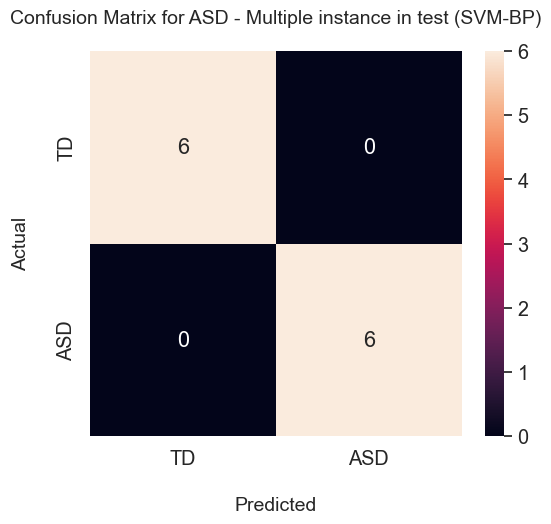

(1.0, 1.0, 1.0, 1.0, 1.0)

In [9]:
# Realizamos predicciones sobre el conjunto de test
y_pred = gs.predict(X_test)

y_pred_ratio = calculate_ratio(y_pred, IDs_test)
print(list(y_pred_ratio.values()))
y_pred_ratio = thresholding(y_pred_ratio, THRESHOLD)
print(y_pred_ratio)
y_pred_df = pd.DataFrame(list(y_pred_ratio.items()), columns=['ParticipantID', 'Prediction_BP'])
metadata = pd.merge(metadata, y_pred_df, on='ParticipantID', how='left')

y_pred_ratio = list(y_pred_ratio.values())
y_test_ratio = calculate_ratio(y_test, IDs_test)
y_test_ratio = [int(val) for val in y_test_ratio.values()]

#y_test_ratio, y_pred_ratio = change_MIL(y_test, y_pred, IDs_test)

results(y_test, y_pred, "Confusion Matrix for ASD - Single instance in test (" + MODEL + "-BP)")
results(y_test_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in test (" + MODEL + "-BP)")

# IA Confiable

## Explainability: detección en la imagen

Se va a estudiar un FN y un FP del conjunto de test para contribuir a la explicabilidad.

In [ ]:
print(y_pred)
print(y_test)
mismatch_index = np.where(y_pred != y_test)[0]

for index in mismatch_index:
    print(f"Índice: {index}, y_pred: {y_pred[index]}, y_test: {y_test[index]}")
    print(IDs_test[index])

[1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Índice: 11, y_pred: 0, y_test: 1
Índice: 13, y_pred: 0, y_test: 1
Índice: 17, y_pred: 0, y_test: 1
Índice: 18, y_pred: 0, y_test: 1
Índice: 31, y_pred: 0, y_test: 1
Índice: 33, y_pred: 0, y_test: 1
Índice: 34, y_pred: 0, y_test: 1
Índice: 40, y_pred: 1, y_test: 0
Índice: 41, y_pred: 1, y_test: 0
Índice: 50, y_pred: 1, y_test: 0
Índice: 52, y_pred: 1, y_test: 0
Índice: 53, y_pred: 1, y_test: 0
Índice: 54, y_pred: 1, y_test: 0
Índice: 65, y_pred: 1, y_test: 0
Índice: 66, y_pred: 1, y_test: 0


Dada una imagen cualquiera con presencia de uno de los objetos, detectar su localización dentro de la imagen.
El mejor modelo para dos clases (X_train e y_train han de ser los de dos clases) con HOG es:

In [8]:
if(MODEL=="KNN"):
    best = KNeighborsClassifier(
        n_neighbors=gs.best_params_['n_neighbors'],
        weights=gs.best_params_['weights'],
        metric=gs.best_params_['metric']
    ).fit(X_train, y_train)
elif(MODEL=="SVM"):
    best = svm.SVC(
        kernel=gs.best_params_['kernel'],
        C=gs.best_params_['C'],
        probability=True
    ).fit(X_train, y_train)
else:
    print("Modelo inválido. Elija 'KNN' o 'SVM'.")

In [94]:
def object_detection(image: np.ndarray, clf: cv2.ml, win_size: tuple[int, int] = (64, 64), stride: tuple[int, int] =(4,4),
                     the_class: int=0, prob_threshold:float =0.95) -> np.ndarray:
    """
    Detects and highlights regions of a class under a probability threshold in an image.
    Uses the classifier clf, a window size, and a stride.

    Parameters:
        image (np.ndarray): Image to work on.
        clf: Classification algorithm with predict and predict_proba functions.
        win_size (tuple[int, int]): Window size.
        stride (tuple[int, int]): Stride.
        the_class (int): Integer representing the class.
        prob_threshold (float): Probability threshold.

    Returns:
        np.ndarray: Image with marked regions if applicable.
    """

    hog = cv2.HOGDescriptor()
    i=0

    for x in range(0, image.shape[1] - win_size[0], stride[0]):
        for y in range(0, image.shape[0] - win_size[1], stride[1]):
            # Obtengo el descriptor de la ventana
            win = image[y:y + win_size[1], x:x + win_size[0]]
            win = cv2.resize(win, (NCOL, NROW))

            # Elimino imágenes en negro
            if np.mean(win) < 1:
                continue

            i = i + 1

            descriptor = hog.compute(win)
            descriptor = np.reshape(descriptor, (1, -1))

            # Realizo la predicción mediante el SVM entrenado
            prediction  = clf.predict(descriptor)
            prob = clf.predict_proba(descriptor)

            # Evalúo la bondad de la predicción
            if prediction  == the_class:
                if the_class==0 and prob[0][0]>=prob_threshold:
                    cv2.rectangle(image, (x, y), (x + win_size[0], y + win_size[1]), (255, 255, 255), 2)
                elif the_class==1 and prob[0][1]>=prob_threshold:
                    cv2.rectangle(image, (x, y), (x + win_size[0], y + win_size[1]), (255, 255, 255), 2)
    print(i)
    return image

def increase_brightness(image: np.ndarray, alpha: float = 1.0, beta: int = 0) -> np.ndarray:
    """
    Increases the brightness of an image.
    
    Parameters:
        image (np.ndarray): Input image.
        alpha (float): Contrast control (1.0-3.0). Default is 1.0 (no change).
        beta (int): Brightness control (0-100). Default is 0 (no change).
    
    Returns:
        np.ndarray: Image with increased brightness.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Increase the brightness
    bright_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    return bright_image

In [101]:
for i in range(len(EXAMPLES_POSITIVE)):
    my_img_pos = cv2.imread(PATH_TRAIN_POSITIVE + EXAMPLES_POSITIVE[i])
    #cv2.imshow("Imagen de ejemplo para deteccion", my_img_pos)
    my_img_pos = cv2.cvtColor(my_img_pos, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Imagen de ejemplo para deteccion (gris)", my_img_pos)

    # Realizar la detección con ventana deslizante
    resultado_pos = object_detection(my_img_pos.copy(), best, (128, 128), (64,64), 1, 0.9999)
    resultado_pos = increase_brightness(resultado_pos, 2, 5)
    if(False):
        cv2.imshow('Resultado detección ASD', resultado_pos)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.imwrite(PATH_RESULT_POSITIVE + EXAMPLES_POSITIVE[i].replace(".png", "_result.png"), resultado_pos)

22
25


In [99]:
for i in range(len(EXAMPLES_NEGATIVE)):
    my_img_neg = cv2.imread(PATH_TRAIN_NEGATIVE + EXAMPLES_NEGATIVE[i])
    #cv2.imshow("Imagen de ejemplo para deteccion", my_img_neg)
    my_img_neg = cv2.cvtColor(my_img_neg, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Imagen de ejemplo para deteccion (gris)", my_img_neg)

    # Realizar la detección con ventana deslizante
    #resultado_neg = object_detection(my_img_neg.copy(), best, (128, 128), (64,64), 0, 0.33)
    resultado_neg = object_detection(my_img_neg.copy(), best, (256, 256), (64,64), 0, 0.77)
    resultado_neg = increase_brightness(resultado_neg, 2, 5)
    if(False):
        cv2.imshow('Resultado detección TD', resultado_neg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.imwrite(PATH_RESULT_NEGATIVE + EXAMPLES_NEGATIVE[i].replace(".png", "_result.png"), resultado_neg)

16
0
15


#### Explicabilidad de KNN

In [102]:
from sklearn.neighbors import KNeighborsClassifier

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [104]:
# Predicción
pred = knn.predict(X_test)

# Obtener los vecinos más cercanos para el primer ejemplo de X_test
distances, indices = knn.kneighbors([X_test[0]], n_neighbors=3)

print("Indices de los vecinos más cercanos:", indices)
print("Distancias de los vecinos más cercanos:", distances)
print(y_test)
print(IDs_test)

Indices de los vecinos más cercanos: [[ 56 167 217]]
Distancias de los vecinos más cercanos: [[21.8819583  22.0398303  22.08097295]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[18 18 18 18 18 18 18 18  9  9  9  5  5  5  5  5  5  5  5  5  5  5  9  8
  8  8  8  8 16 16 23 23 23 23 23 23 31 31 31 31 48 48 48 48 55 55 48 48
 48 48 53 53 53 53 53 56 56 56 53 53 38 38 38 38 38 38 38]


In [110]:
IDs_train[indices]

array([[19, 17, 14]])

## Fairness

Con el objetivo de mejorar la equidad se van a tener en cuenta las siguientes métricas de equidad.

In [30]:
def disparate_impact(y_pred: list[int], protected_attribute: list[int], privileged_group: int = 1) -> float:
    """
    Calculates disparate impact.

    Parameters:
        y_pred (list[int]): Model predictions.
        y_true (list[int]): True values.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        float: Disparate impact value. Values close to 1 indicate greater fairness.
    """
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)

    privileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute == privileged_group)) /
        np.sum(protected_attribute == privileged_group))
    unprivileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute != privileged_group)) /
        np.sum(protected_attribute != privileged_group))

    if(privileged_positive_rate!=0):
        disparate_impact_value = unprivileged_positive_rate / (privileged_positive_rate)
    else:
        disparate_impact_value = 0
        raise ValueError("Privileged postive rate is 0.")

    return disparate_impact_value

def demographic_parity(y_pred: list[int], protected_attribute: list[int], privileged_group: int = 1) -> float:
    """
    Calculates demographic parity.

    Parameters:
        y_pred (list[int]): Model predictions.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        float: Demographic parity value. Lower values indicate more similar acceptance rates and thus greater fairness.
    """
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)

    privileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute == privileged_group)) /
        np.sum(protected_attribute == privileged_group))
    unprivileged_positive_rate = (
        np.sum((y_pred == 1) & (protected_attribute != privileged_group)) /
        np.sum(protected_attribute != privileged_group))

    demographic_parity_value = privileged_positive_rate - unprivileged_positive_rate

    return demographic_parity_value

def equalized_odds(y_pred: list[int], y_true: list[int], protected_attribute: list[int],
                   privileged_group: int = 1) -> tuple[float, float]:
    """
    Calculates equalized odds.

    Parameters:
        y_pred (list[int]): Model predictions.
        y_true (list[int]): True values.
        protected_attribute (list[int]): Protected attribute (e.g., gender).
        privileged_group (int): Privileged group (value of the protected attribute).

    Returns:
        dict: Dictionary with FPR and TPR differences. Lower values indicate greater fairness.
    """
    # Convert lists to numpy arrays for ease of manipulation
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    protected_attribute = np.array(protected_attribute)

    # Calculate FPR and TPR for the privileged group
    priv_negatives = (y_true == 0) & (protected_attribute == privileged_group)
    priv_positives = (y_true == 1) & (protected_attribute == privileged_group)
    priv_fpr = np.sum((y_pred == 1) & priv_negatives) / np.sum(priv_negatives)
    priv_tpr = np.sum((y_pred == 1) & priv_positives) / np.sum(priv_positives)

    # Calculate FPR and TPR for the unprivileged group
    unpriv_negatives = (y_true == 0) & (protected_attribute != privileged_group)
    unpriv_positives = (y_true == 1) & (protected_attribute != privileged_group)
    unpriv_fpr = np.sum((y_pred == 1) & unpriv_negatives) / np.sum(unpriv_negatives)
    unpriv_tpr = np.sum((y_pred == 1) & unpriv_positives) / np.sum(unpriv_positives)

    # Calculate the differences
    fpr_difference = np.abs(priv_fpr - unpriv_fpr)
    tpr_difference = np.abs(priv_tpr - unpriv_tpr)

    return fpr_difference, tpr_difference


In [33]:
metadata_filtrado = metadata.dropna(subset=['Prediction_BP'])

y_pred_clean = metadata_filtrado['Prediction_BP'].tolist()
y_true_clean = metadata_filtrado['Class'].map({'TS': 1, 'TC': 0}).tolist()
y_prot_clean = metadata_filtrado['Gender'].map({'M': 1, 'F': 0}).tolist()

if(True):
    #print(metadata_filtrado)
    print(y_pred_clean)
    print(y_true_clean)
    print(y_prot_clean)

print("Disparate impact: {:.2f}".format(disparate_impact(y_pred_clean, y_prot_clean)))
print("Demographic parity: {:.2f}".format(demographic_parity(y_pred_clean, y_prot_clean)))
print("Equalized_odds: " + str(equalized_odds(y_pred_clean, y_true_clean, y_prot_clean)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Disparate impact: 0.40
Demographic parity: 0.38
Equalized_odds: (0.0, 0.0)


## Privacy: Federated Learning

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def train_local_model(X_train_local: np.ndarray, y_train_local: np.ndarray) -> SVC:
    """
    Entrena un modelo SVC con kernel polinomial y C=1 en los datos locales.

    Parameters:
        X_train_local (np.ndarray): Datos de entrenamiento locales.
        y_train_local (np.ndarray): Etiquetas de entrenamiento locales.

    Returns:
        SVC: El modelo SVC entrenado.
    """
    svc = SVC(kernel='poly', C=1, probability=True)
    svc.fit(X_train_local, y_train_local)
    return svc

def average_predictions(models: list[SVC], X_test: np.ndarray) -> np.ndarray:
    """
    Combina las predicciones de los modelos locales usando el promedio de probabilidades.

    Parameters:
        models (list[SVC]): Lista de modelos entrenados.
        X_test (np.ndarray): Datos de prueba.

    Returns:
        np.ndarray: Predicciones combinadas.
    """
    probs = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        probs[:, i] = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva

    avg_probs = np.mean(probs, axis=1)
    return np.where(avg_probs > 0.5, 1, 0)  # Clasificar basado en el promedio de probabilidades

def evaluate_global_model(global_predictions: np.ndarray, y_test: np.ndarray) -> float:
    """
    Evalúa la precisión del modelo global en el conjunto de datos de prueba.

    Parameters:
        global_predictions (np.ndarray): Predicciones del modelo global.
        y_test (np.ndarray): Etiquetas reales de prueba.

    Returns:
        float: Precisión del modelo global.
    """
    accuracy = accuracy_score(y_test, global_predictions)
    return accuracy

def federated_learning(X_train_global: np.ndarray, y_train_global: np.ndarray,
                       X_test: np.ndarray, y_test: np.ndarray,
                       num_devices: int, num_rounds: int) -> float:
    """
    Entrena un modelo global utilizando Aprendizaje Federado y evalúa su precisión.

    Parameters:
        X_train_global (np.ndarray): Datos de entrenamiento globales.
        y_train_global (np.ndarray): Etiquetas de entrenamiento globales.
        X_test (np.ndarray): Datos de prueba.
        y_test (np.ndarray): Etiquetas de prueba.
        num_devices (int): Número de dispositivos.
        num_rounds (int): Número de rondas de entrenamiento.

    Returns:
        float: Precisión del modelo global.
    """
    skf = StratifiedKFold(n_splits=num_devices)

    id_to_label = {}
    for id, label in zip(IDs_train, y_train_global):
        if id not in id_to_label:
            id_to_label[id] = label
    
    unique_ids = list(id_to_label.keys())
    labels = list(id_to_label.values())
    
    for round in range(num_rounds):
        print("Round:", round+1)
        local_models = []
        i=1
        
        # Dividir el conjunto de datos global en dispositivos locales
        for train_index, _ in skf.split(unique_ids, labels):
            print("    Hospital ", i)
            i += 1

            local_ids = [unique_ids[i] for i in train_index]
            local_mask = np.isin(IDs_train, local_ids)
            X_train_local = X_train_global[local_mask]
            y_train_local = y_train_global[local_mask]
            
            # Entrenar modelos locales en cada dispositivo
            local_model = train_local_model(X_train_local, y_train_local)
            local_models.append(local_model)
        
        # Combinar las predicciones de los modelos locales en el conjunto de prueba
        global_predictions = average_predictions(local_models, X_test)
        
        accuracy = evaluate_global_model(global_predictions, y_test)
        print("    Accuracy on test set:", accuracy)
    
    return local_models

num_devices = 2  # Número de hospitales
num_rounds = 5   # Número de rondas de entrenamiento
local_models = federated_learning(X_train, y_train, X_test, y_test, num_devices, num_rounds)

Round: 1
    Hospital  1
    Hospital  2
    Accuracy on test set: 0.7761194029850746
Round: 2
    Hospital  1
    Hospital  2
    Accuracy on test set: 0.8059701492537313
Round: 3
    Hospital  1
    Hospital  2
    Accuracy on test set: 0.7611940298507462
Round: 4
    Hospital  1
    Hospital  2
    Accuracy on test set: 0.8059701492537313
Round: 5
    Hospital  1
    Hospital  2
    Accuracy on test set: 0.8059701492537313


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.625, 0.0, 0.7142857142857143, 0.0, 0.42857142857142855]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]
{'Accuracy': 0.806, 'Precision': 0.735, 'Sensitivity_recall': 1.0, 'Specificity': 0.581, 'F1_score': 0.847}


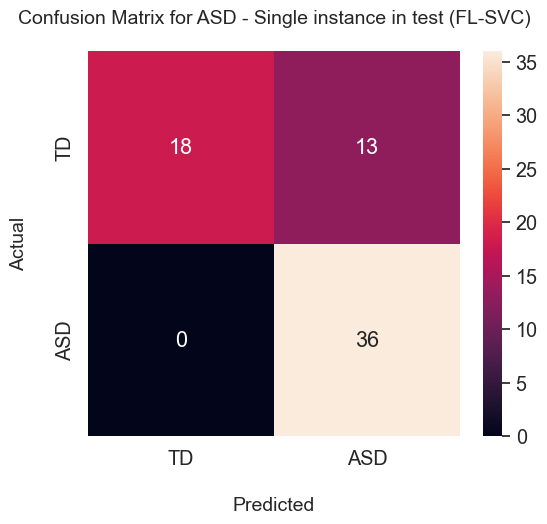

{'Accuracy': 0.833, 'Precision': 0.75, 'Sensitivity_recall': 1.0, 'Specificity': 0.667, 'F1_score': 0.857}


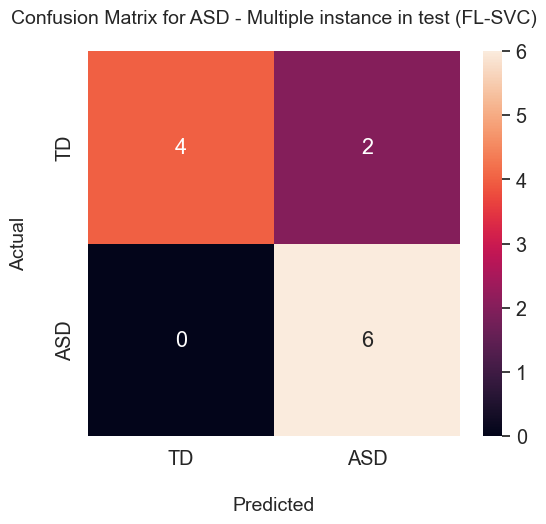

(0.833, 0.75, 1.0, 0.667, 0.857)

In [11]:
# Realizamos predicciones sobre el conjunto de test
y_pred = average_predictions(local_models, X_test)
y_test_ratio, y_pred_ratio = change_MIL(y_test, y_pred, IDs_test, True)
print(y_test_ratio)
print(y_pred_ratio)

results(y_test, y_pred, "Confusion Matrix for ASD - Single instance in test (FL-SVC)")
results(y_test_ratio, y_pred_ratio, "Confusion Matrix for ASD - Multiple instance in test (FL-SVC)")

# Clasificación multiclase

El primer paso es construir las listas con las salidas multiclase, es decir, en vez de ser una clasificación binaria va a ser una clasificación multiclase según grados de severidad. Por tanto, las etiquetas van ahora de 0 a 3.

In [48]:
def get_cars_scores(IDs_train: list[str], metadata: pd.DataFrame) -> list[float]:
    """
    Busca cada ID en el DataFrame metadata y extrae el valor de Cars_Score.

    Parameters:
        IDs_train (list[str]): Lista de IDs a buscar.
        metadata (pd.DataFrame): DataFrame con las columnas 'ParticipantID' y 'CARS Score'.

    Returns:
        list[float]: Lista con los valores de Cars_Score correspondientes a los IDs en IDs_train.
                     Los valores NaN se reemplazan con 0.0.
    """
    cars_scores = []

    for ID in IDs_train:
        score = metadata.loc[metadata['ParticipantID'] == ID, 'CARS Score']
        
        if not score.empty:
            if not pd.isna(score.iloc[0]):
                cars_scores.append(float(score.iloc[0]))
            else:
                cars_scores.append(0.0)
        else:
            print("ID {ID} no se encontró en los metadatos.")

    return cars_scores

def discretize(y_cont: np.ndarray) -> np.ndarray:
    """
    Discretiza un array continuo en clases ordinales basadas en límites predefinidos.

    Parameters:
        y_cont (np.ndarray): Array de valores continuos a discretizar.

    Returns:
        np.ndarray: Array de valores discretizados en clases ordinales.
    """
    bins = [-np.inf, 15, 30, 36.5, np.inf]
    labels = [0, 1, 2, 3]
    y_indices = np.digitize(y_cont, bins) - 1  # np.digitize devuelve índices que empiezan en 1
    y_disc = np.array([labels[idx] for idx in y_indices])

    return y_disc

# Se obtienen los CARS scores a través del csv con los metadatos
y_train_multi = get_cars_scores(IDs_train, metadata)
y_test_multi = get_cars_scores(IDs_test, metadata)

# Se discretizan según el estándar CARS.
y_train_multi_disc = discretize(y_train_multi)
y_test_multi_disc = discretize(y_test_multi)

Enfoque con SVC

In [49]:
from sklearn.metrics import confusion_matrix

# Función de pérdida personalizada para penalización por tipo de error
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    penalties = np.array([
        [0, 1, 2, 3],  # No hay autismo (clase 0)
        [1, 0, 1, 2],  # Autismo bajo (clase 1)
        [2, 1, 0, 1],  # Autismo medio (clase 2)
        [3, 2, 1, 0]   # Autismo alto (clase 3)
    ])
    return np.sum(cm * penalties)

# Entrenar un modelo SVC con kernel 'poly'
model = svm.SVC(kernel='poly', C=1, probability=True)
model.fit(X_train, y_train_multi_disc)

SVC(C=1, kernel='poly', probability=True)

[2.1818181818181817, 0.9777777777777777, 0.9791666666666666, 3.0, 2.0, 3.0, 2.0, 0.9393939393939394, 0.9333333333333333, 0.4, 0.7222222222222222, 0.8666666666666667, 0.7857142857142857, 1.7575757575757576, 0.8974358974358975, 2.5714285714285716, 2.0, 1.5, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 1, 1, 3, 2, 3, 2, 1, 1, 2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 3, 2, 3, 2, 1, 1, 0, 1, 1, 1, 2, 1, 3, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.945}


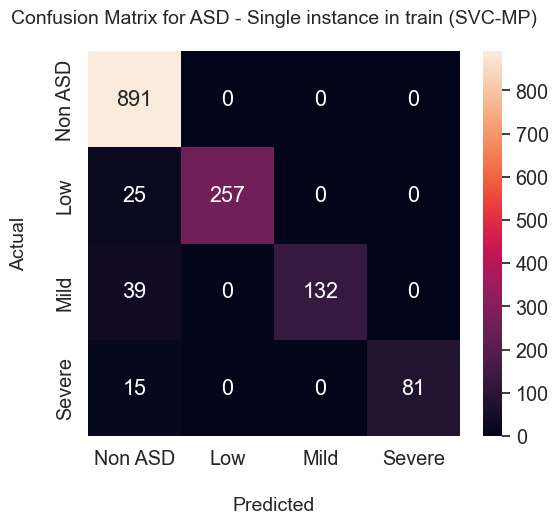

{'Accuracy': 0.905}


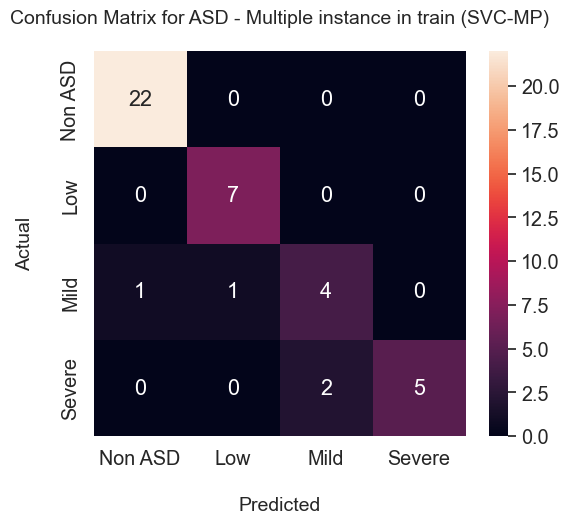

array([[22,  0,  0,  0],
       [ 0,  7,  0,  0],
       [ 1,  1,  4,  0],
       [ 0,  0,  2,  5]], dtype=int64)

In [63]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_train)

# Evaluar el modelo con la función de pérdida personalizada
#loss = custom_loss(y_train_multi_disc, y_pred)
#print(f'Custom loss: {loss}')

y_train_multi_ratio, y_pred_multi_ratio = change_MIL_multiclass(y_train_multi_disc, y_pred, IDs_train, True)
print(y_train_multi_ratio)
print(y_pred_multi_ratio)

print({"Accuracy":metrics.accuracy_score(y_train_multi_disc, y_pred).round(NDEC)})
confusion_matrix_customized(y_train_multi_disc, y_pred, "Confusion Matrix for ASD - Single instance in train (SVC-MP)", CLASSES_MP)

print({"Accuracy":metrics.accuracy_score(y_train_multi_ratio, y_pred_multi_ratio).round(NDEC)})
confusion_matrix_customized(y_train_multi_ratio, y_pred_multi_ratio,
                            "Confusion Matrix for ASD - Multiple instance in train (SVC-MP)", CLASSES_MP)

[2.5, 2.25, 0.45454545454545453, 2.0, 1.5, 1.1666666666666667, 0.0, 0.375, 0.0, 0.42857142857142855, 0.0, 0.42857142857142855]
[2, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0]
[2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.373}


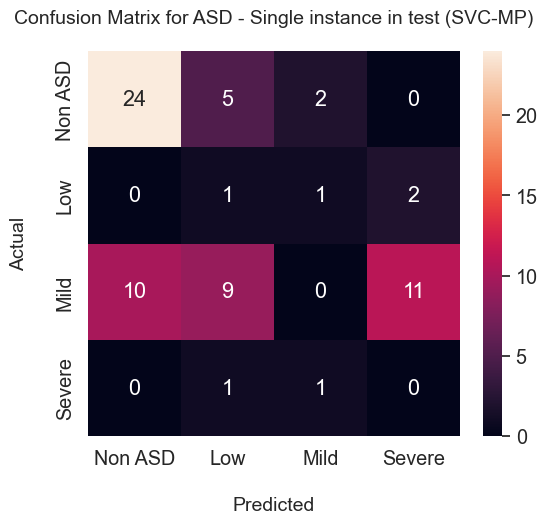

{'Accuracy': 0.75}


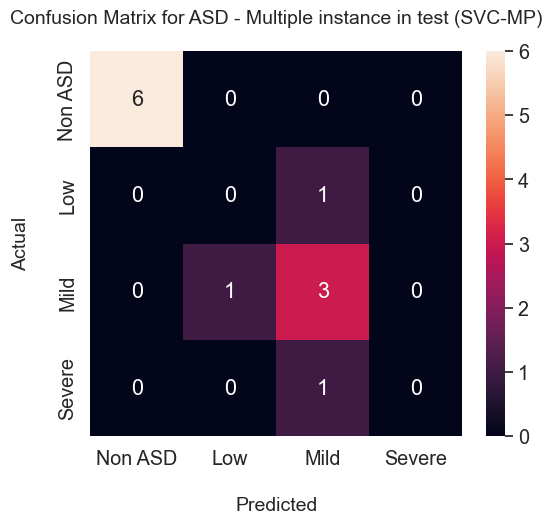

array([[6, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 3, 0],
       [0, 0, 1, 0]], dtype=int64)

In [62]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo con la función de pérdida personalizada
#loss = custom_loss(y_test_multi_disc, y_pred)
#print(f'Custom loss: {loss}')

y_test_multi_ratio, y_pred_multi_ratio = change_MIL_multiclass(y_test_multi_disc, y_pred, IDs_test, True)
print(y_test_multi_ratio)
print(y_pred_multi_ratio)

print({"Accuracy":metrics.accuracy_score(y_test_multi_disc, y_pred).round(NDEC)})
confusion_matrix_customized(y_test_multi_disc, y_pred, "Confusion Matrix for ASD - Single instance in test (SVC-MP)", CLASSES_MP)

print({"Accuracy":metrics.accuracy_score(y_test_multi_ratio, y_pred_multi_ratio).round(NDEC)})
confusion_matrix_customized(y_test_multi_ratio, y_pred_multi_ratio,
                            "Confusion Matrix for ASD - Multiple instance in test (SVC-MP)", CLASSES_MP)

Enfoque con SVM

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Definir el modelo SVR y el grid search
svr = SVR(kernel='poly')

# Parámetros para GridSearchCV
#params = {'C': [1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0, 1, 10]}
params = {'C': [1], 'degree': [4], 'coef0': [0]}

# Configurar GridSearchCV
gs = GridSearchCV(estimator=svr, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gs = gs.fit(X_train, y_train_multi)

# Seleccionar el mejor modelo
best_model = gs.best_estimator_
print("Best parameters:", gs.best_params_)

Best parameters: {'C': 1, 'coef0': 0, 'degree': 4}


In [57]:
# Predecir con el mejor modelo
y_pred_multi = best_model.predict(X_test)
y_pred_multi_disc = discretize(y_pred_multi)
# Evaluar el modelo (usando error cuadrático medio como ejemplo)
mse = mean_squared_error(y_test_multi, y_pred_multi)
print(f"Mean Squared Error on test set: {mse:.2f}")

# Mostrar predicciones discretas y continuas
print("Continuous predictions:", y_pred_multi)
print("True labels:", y_test_multi)
print("Discretized predictions:", y_pred_multi_disc)
print("True labels:", y_test_multi_disc)

Mean Squared Error on test set: 274.79
Continuous predictions: [ 3.62250308e+01  3.11694103e+01  6.50258332e+01  2.15381708e+01
  2.93850306e+01  1.85218741e+01  1.08730945e+01  2.53598925e+01
  3.74944064e+01  9.27589512e+00  7.57687633e+01  2.91935179e+00
  5.05693727e+00  4.20022953e+00  1.80154194e+01  7.96222449e+00
  6.99948341e+00  2.46857448e+00  3.43494044e+00  1.07209986e+01
  1.48291522e+01  1.23737602e+01  2.92332448e+01  1.17227492e+01
  3.64057213e+01  4.32387263e+01  5.15312342e+00  5.58928793e+01
  1.84476376e+01  1.42868089e+01  1.08859267e+01  3.85676468e+00
  2.25095230e+01  7.96149091e+00  4.03412256e+00  5.32823745e+01
  6.61773491e-02  1.57804822e+00 -5.60035717e-02  3.47538587e-01
  1.76003679e+01  3.87484807e+00  4.66114162e+00  1.55251354e+00
 -1.41899392e-02  6.18256782e-01  1.53677672e+00  3.32690242e-01
  1.42019234e+00  1.09394344e+00  2.00433257e+01  3.12974543e+00
  5.42550252e+00  5.53707794e+00  1.13593395e+01  3.82696549e-01
  1.81805099e-01  4.1293159

[1.375, 1.75, 0.09090909090909091, 1.6, 0.5, 0.6666666666666666, 0.0, 0.125, 0.0, 0.14285714285714285, 0.0, 0.14285714285714285]
[2, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0]
[2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0]
{'Accuracy': 0.388}


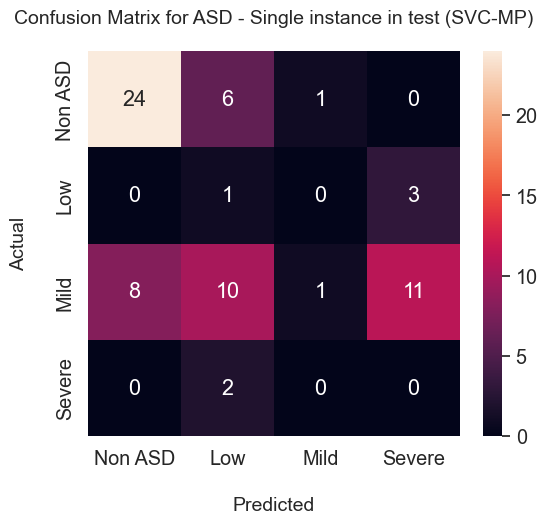

{'Accuracy': 0.667}


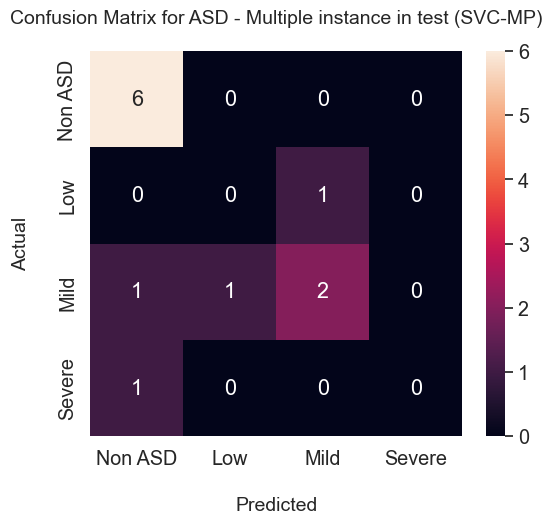

array([[6, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 1, 2, 0],
       [1, 0, 0, 0]], dtype=int64)

In [58]:
y_test_multi_ratio, y_pred_multi_ratio = change_MIL_multiclass(y_test_multi_disc, y_pred_multi_disc, IDs_test, True)
print(y_test_multi_ratio)
print(y_pred_multi_ratio)

print({"Accuracy":metrics.accuracy_score(y_test_multi_disc, y_pred).round(NDEC)})
confusion_matrix_customized(y_test_multi_disc, y_pred, "Confusion Matrix for ASD - Single instance in test (SVC-MP)", CLASSES_MP)

print({"Accuracy":metrics.accuracy_score(y_test_multi_ratio, y_pred_multi_ratio).round(NDEC)})
confusion_matrix_customized(y_test_multi_ratio, y_pred_multi_ratio,
                            "Confusion Matrix for ASD - Multiple instance in test (SVC-MP)", CLASSES_MP)